In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - Open Models (Llama 3.2 and Stable Diffusion 2.1)

Author: [Wan Qi Ang](https://github.com/angwanqi) for 2024 EDB x Google Cloud - Cloud AI Take Off Program

Last updated: 30 October 2024

## Overview

This notebook demonstrates how you can call open models that are deployed on Vertex AI Prediction. The 2 models in this notebook are:
 * [Llama 3.2](https://console.cloud.google.com/vertex-ai/publishers/meta/model-garden/llama3-2)
 * [Stable Diffusion 2.1](https://console.cloud.google.com/vertex-ai/publishers/stability-ai/model-garden/stable-diffusion-2-1)

### Objective

* Send requests to the Vertex AI Prediction Endpoint that is hosting Llama 3.2
* Send requests to the Vertex AI Prediction Endpoint that is hosting Stable Diffusion 2.1


### Assumptions
- The models are already deployed via Model Garden's one-click deploy feature

## Before you begin

### Installation
Run the cell below if this is your first time running the notebook. Else, feel free to skip the cell below as the libraries would have already been installed.

In [ ]:
%pip install --upgrade --user --quiet google-cloud-aiplatform
! git clone https://github.com/GoogleCloudPlatform/vertex-ai-samples.git

### Restart current runtime
To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.
<div class="alert alert-block alert-success"> 
<b>NOTE:</b> Only restart the current runtime if you installed libraries. If you did not install new libraries, you do not need to restart the kernel.
</div>

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Import libraries

In [12]:
import datetime
import importlib
import os
import uuid
from typing import Tuple
import math

from google.cloud import aiplatform

common_util = importlib.import_module(
    "vertex-ai-samples.community-content.vertex_model_garden.model_oss.notebook_util.common_util"
)

### Set your project ID and region

In [ ]:
# Get the default cloud project id.
PROJECT_ID= !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

print(f"Project ID:", PROJECT_ID)

aiplatform.init(project=PROJECT_ID)

endpoints = {}

## Predicting with Vertex AI Prediction Endpoints

After you've deployed your target model to a Vertex AI Prediction Endpoint, you can send requests to the endpoint with text prompts based on your `template`. Note that the first few prompts will take longer to execute. 

First, let's retrieved the details of the endpoints

In [ ]:
# Retrieve the Vertex AI Prediction Endpoint IDs and set it
check_regions = ["us-central1", "asia-southeast1", "europe-west4"]

for region in check_regions:
    all_endpoints = aiplatform.Endpoint.list(location=region)
    for endpoint in all_endpoints:
        full_endpoint = f"projects/{PROJECT_ID}/locations/{region}/endpoints/{endpoint.name}"
        
        if endpoint.display_name == "llama-3-2-11b-vision-mg-one-click-deploy":
            endpoints['llama3-2'] = aiplatform.Endpoint(full_endpoint)
        
        if endpoint.display_name == "stabilityai_stable-diffusion-2-1-mg-one-click-deploy":
            endpoints['sd2-1'] = aiplatform.Endpoint(full_endpoint)

### Predicting with Llama 3.2
**Example:**
```
> What is a car?
```

**Note:**
If you encounter the issue like `ServiceUnavailable: 503 Took too long to respond when processing`, you can reduce the maximum number of output tokens, such as set `max_tokens` as 20.

In [9]:
prompt = "What is a car?"

max_tokens = 50
temperature = 1.0
top_p = 1.0
top_k = 1

# Overrides parameters for inferences.
instances = [
    {
        "prompt": prompt,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "top_p": top_p,
        "top_k": top_k,
    },
]

llama3_response = endpoints['llama3-2'].predict(instances=instances)
for prediction in llama3_response.predictions:
    print(prediction)

Prompt:
What is a car?
Output:
 A car is a road vehicle, typically with four wheels, powered by an internal combustion engine or an electric motor. Cars are used for transportation, recreation, and other purposes. They come in various shapes, sizes, and models, ranging from small hatch


### Generating Images with Stable Diffusion 2.1

After your model is deployed, you'll be able to generate images by sending text prompts to the endpoint. Try your hand at generating some images below! 

**Example:**
```
> A photo of an astronaut riding a horse on mars
> A stone castle in a forest by the river
```

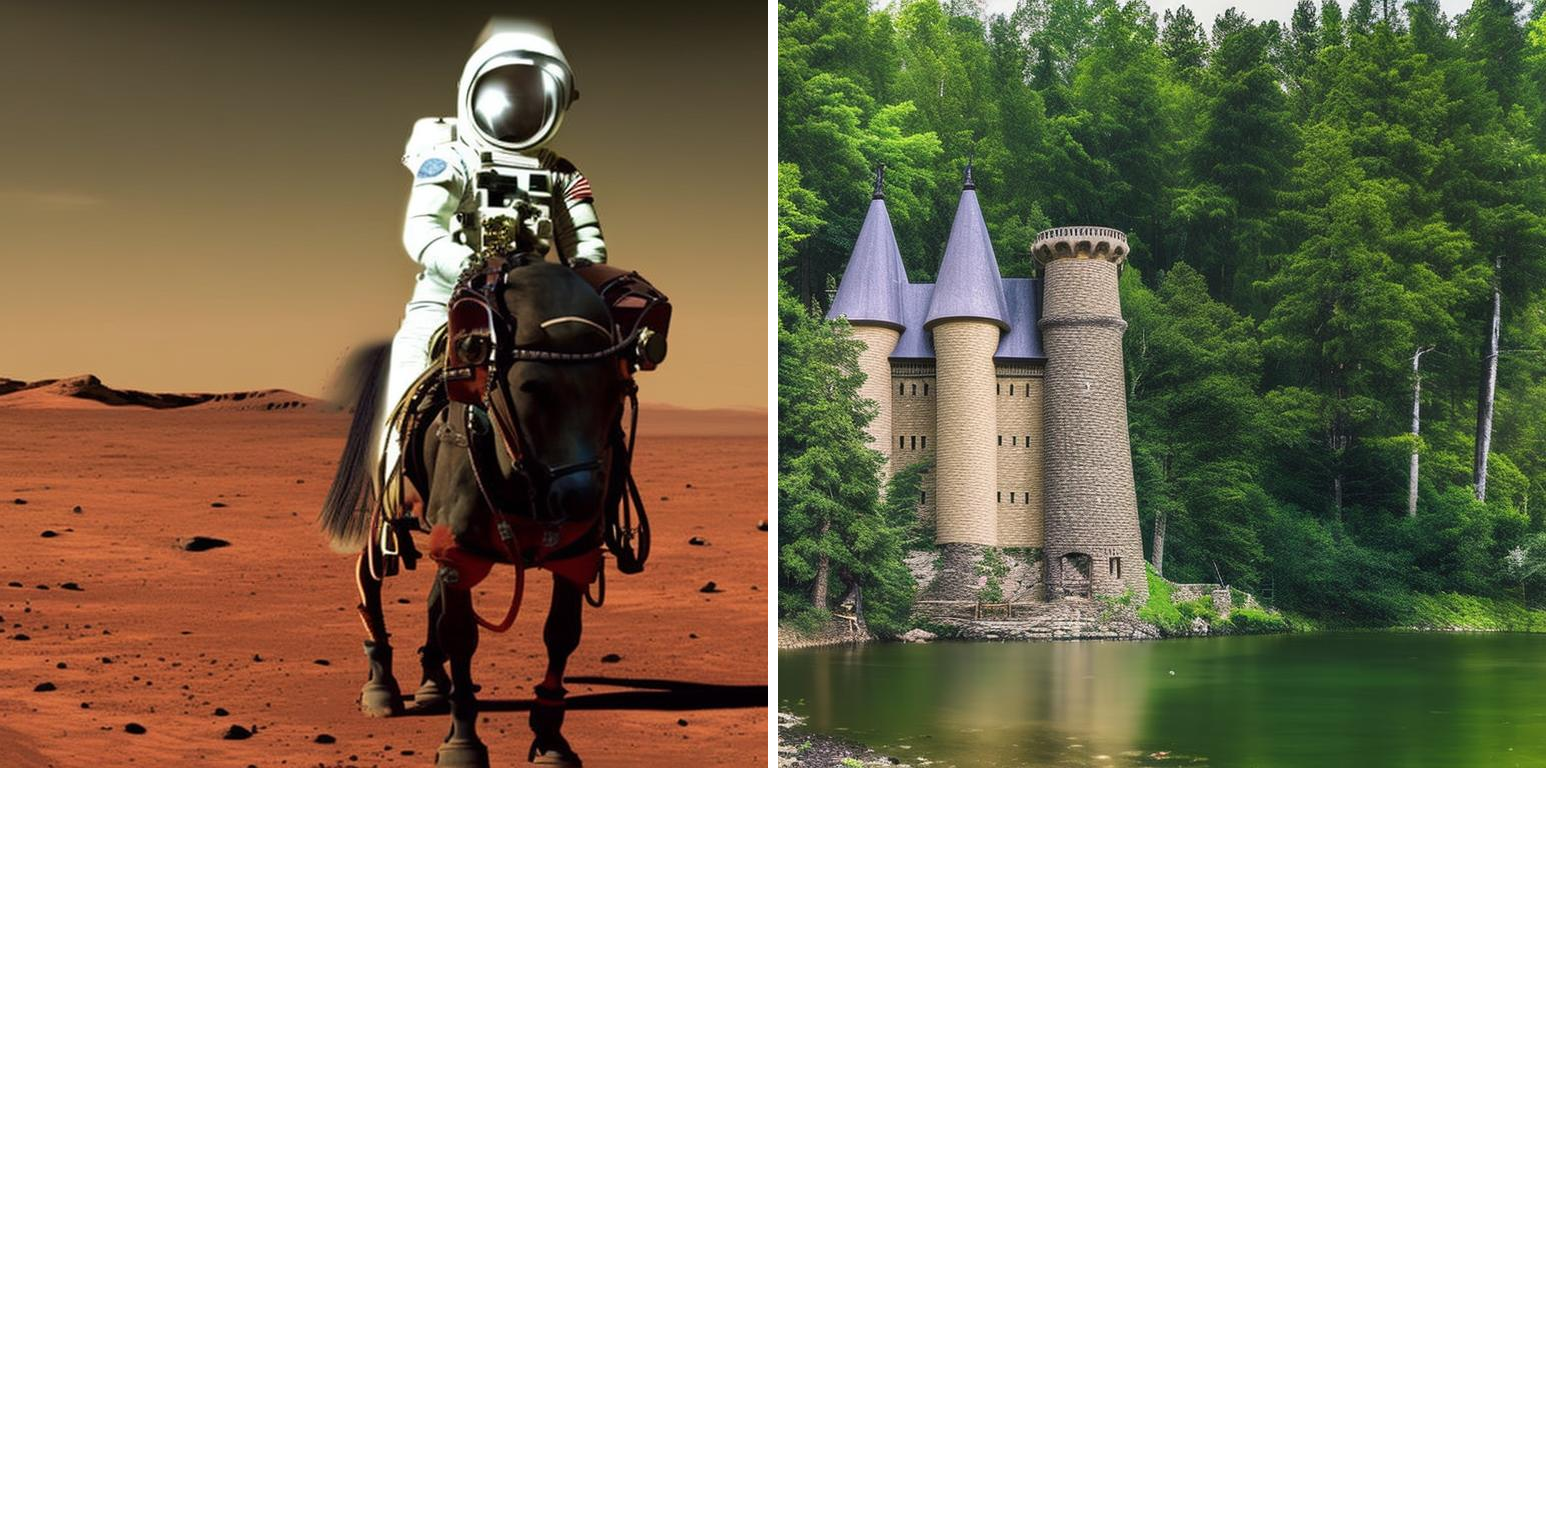

In [14]:
# Create your prompts by adding them to a prompt list

comma_separated_prompt_list = "A photo of an astronaut riding a horse on mars, A stone castle in a forest by the river"  # @param {type: "string"}
prompt_list = [x.strip() for x in comma_separated_prompt_list.split(",")]

# [Optional] Set a negative prompt to define what you don't want to see.
negative_prompt = ""

# Set parameters
height = 768
width = 768
num_inference_steps = 25
guidance_scale = 7.5


# Construct instance list
instances = [{"text": prompt} for prompt in prompt_list]
parameters = {
    "negative_prompt": negative_prompt,
    "height": height,
    "width": width,
    "num_inference_steps": num_inference_steps,
    "guidance_scale": 7.5,
}

# Send prompts and parameters to the endpoint
response = endpoints['sd2-1'].predict(
    instances=instances, parameters=parameters
)

# Display the generated images
images = [
    common_util.base64_to_image(prediction.get("output"))
    for prediction in response.predictions
]
display(common_util.image_grid(images, rows=math.ceil(len(images) ** 0.5)))